**IBM Stock Prediction**

Build a trading (security) strategy for future stock purchases based on historical values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

**Importing data, pre-processing, & cleaning the data.**

In [2]:
ibm = yf.download("IBM", start = "1960-01-01", end = "2021-12-31")

[*********************100%%**********************]  1 of 1 completed


**Cleaning null values & analyzing basic data info.**

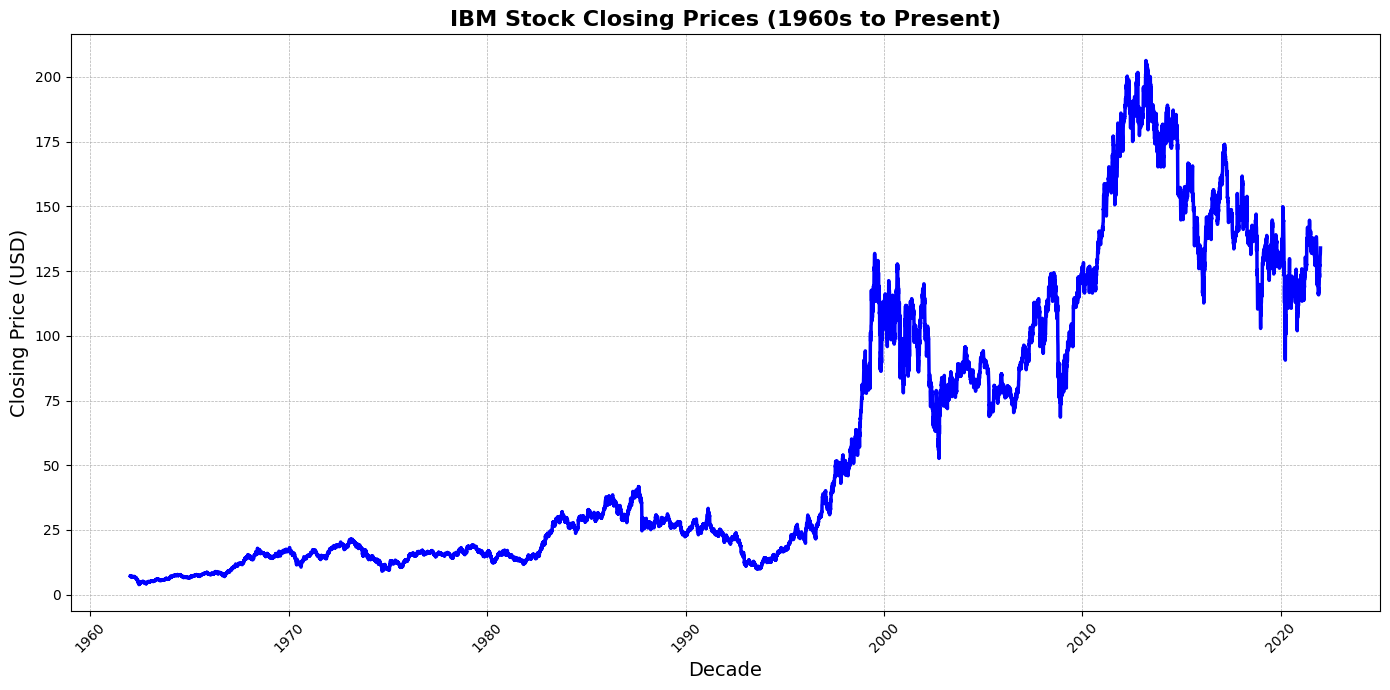

In [3]:
ibm = ibm.dropna(axis = 0)

plt.figure(figsize = (14, 7))
ax = sns.lineplot(x = ibm.index, y = "Close", data = ibm, color = "blue", linewidth = 2.5)

ax.set_title("IBM Stock Closing Prices (1960s to Present)", fontsize = 16, fontweight = "bold")
ax.set_ylabel("Closing Price (USD)", fontsize = 14)
ax.set_xlabel("Decade", fontsize = 14)

plt.xticks(rotation = 45)
ax.grid(True, which = "both", linestyle = "--", linewidth = 0.5)

plt.tight_layout()
plt.show()

In [4]:
ibm = ibm.dropna(axis = 0)

trace = go.Scatter(x = ibm.index, y = ibm["Close"], mode = "lines")
layout = go.Layout(title = dict(text = "IBM Stock Closing Prices (1960s to Present)", x = 0.5, xanchor = "center"),
                                xaxis = dict(title = "Decade"), yaxis = dict(title = "Closing Price"))

fig = go.Figure(data = [trace], layout = layout)
fig.show()

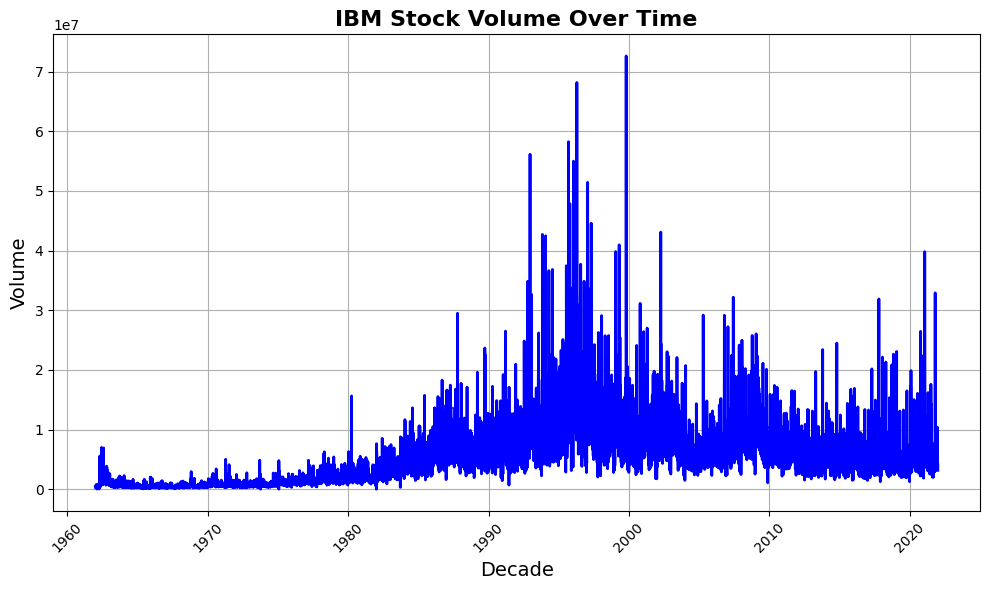

In [5]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(ibm.index, ibm["Volume"], color = "blue", linewidth = 2)

ax.set_title("IBM Stock Volume Over Time", fontsize = 16, fontweight = "bold")
ax.set_xlabel("Decade", fontsize = 14)
ax.set_ylabel("Volume", fontsize = 14)

plt.xticks(rotation = 45)
ax.grid()

plt.tight_layout()
plt.show()

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = ibm.index, y = ibm["Volume"], mode = "lines", line = dict(color = "blue", width = 2),
                         name = "Volume"))

fig.update_layout(
    title = {"text": "IBM Stock Volume Over Time", "x": 0.5, "xanchor": "center",
             "font": dict(size = 16, family = "Arial")},
    xaxis = dict(title = "Decade", titlefont = dict(size = 14), tickangle = 45),
    yaxis = dict(title = "Volume", titlefont = dict(size = 14)),
    plot_bgcolor = "white",
    xaxis_gridcolor = "gray",
    yaxis_gridcolor = "gray",
    margin = dict(l = 40, r = 40, t = 40, b = 40))

fig.show()

In [7]:
ibm.isnull().values.any()

False

In [8]:
ibm.shape

(15104, 6)

In [9]:
ibm["Adj Close Next Day"] = ibm["Adj Close"].shift(periods = -1)
ibm.tail(3)

,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day
Date,,,,,,,
2021-12-28,131.600006,133.220001,131.589996,132.630005,118.123955,3445200,118.765205
2021-12-29,132.399994,134.210007,132.300003,133.350006,118.765205,4239900,119.263969
2021-12-30,133.750000,134.369995,133.330002,133.910004,119.263969,3158100,NaN


In [10]:
ibm.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Adj Close Next Day'],
      dtype='object')

In [11]:
ibm.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,15104.0,5.940773e+01,5.515870e+01,3.900574,1.550550e+01,2.826243e+01,1.042065e+02,2.059082e+02
High,15104.0,5.995836e+01,5.560630e+01,4.098152,1.560409e+01,2.856119e+01,1.055957e+02,2.064053e+02
Low,15104.0,5.888630e+01,5.474282e+01,3.824092,1.538599e+01,2.805330e+01,1.028812e+02,2.048757e+02
Close,15104.0,5.942563e+01,5.518229e+01,3.900574,1.550550e+01,2.826243e+01,1.042137e+02,2.063098e+02
Adj Close,15104.0,3.505781e+01,3.953575e+01,0.816895,4.084010e+00,1.139232e+01,5.856540e+01,1.310615e+02
Volume,15104.0,5.099940e+06,4.661623e+06,0.000000,1.447978e+06,4.323850e+06,7.123574e+06,7.263916e+07
Adj Close Next Day,15103.0,3.506003e+01,3.953612e+01,0.816895,4.084164e+00,1.139322e+01,5.857150e+01,1.310615e+02


**Plotting Data**

<Figure size 500x500 with 0 Axes>

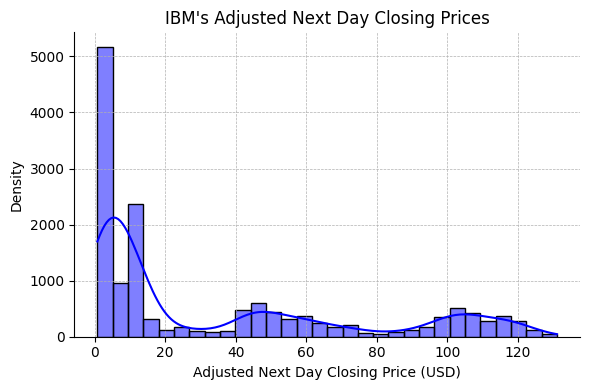

In [12]:
ibm = ibm.dropna(axis = 0)

plt.figure(figsize = (5, 5))
ax = sns.displot(ibm["Adj Close Next Day"], kde = True, color = "blue", height = 4, aspect = 1.5)
ax.set(title = "IBM's Adjusted Next Day Closing Prices",
       xlabel = "Adjusted Next Day Closing Price (USD)", ylabel = "Density")

plt.grid(True, which = "both", linestyle = "--", linewidth = 0.5)

plt.tight_layout()
plt.show()

<Figure size 500x500 with 0 Axes>

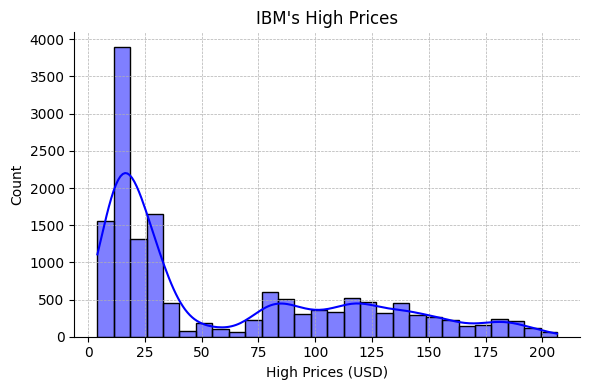

In [13]:
ibm = ibm.dropna(axis = 0)

plt.figure(figsize = (5, 5))
ax = sns.displot(ibm["High"], kde = True, color = "blue", height = 4, aspect = 1.5)
ax.set(title = "IBM's High Prices",
       xlabel = "High Prices (USD)", ylabel = "Count")

plt.grid(True, which = "both", linestyle = "--", linewidth = 0.5)

plt.tight_layout()
plt.show()

**Strategy 1: "buy" = next trading day's close price > today's close price; otherwise, "sell".**

In [14]:
strategy1 = ibm.copy()
strategy1["Y1"] = np.where(strategy1["Close"].shift(-1) > strategy1["Close"], 1, 0)

strategy1.dropna().head(3)

,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day,Y1
Date,,,,,,,,
1962-01-02,7.374124,7.374124,7.291268,7.291268,1.526557,407940,1.539901,1
1962-01-03,7.291268,7.355003,7.291268,7.355003,1.539901,305955,1.524555,0
1962-01-04,7.355003,7.355003,7.278521,7.281708,1.524555,274575,1.494531,0


**Strategy 2 utilizes 50-day moving average for short-term & 200-day moving average for long-term.**

The target variable, y, also known as the signal, should either be a buy signal (y = 1) or sell signal (y = -1) of the stock based on feature variables (x).

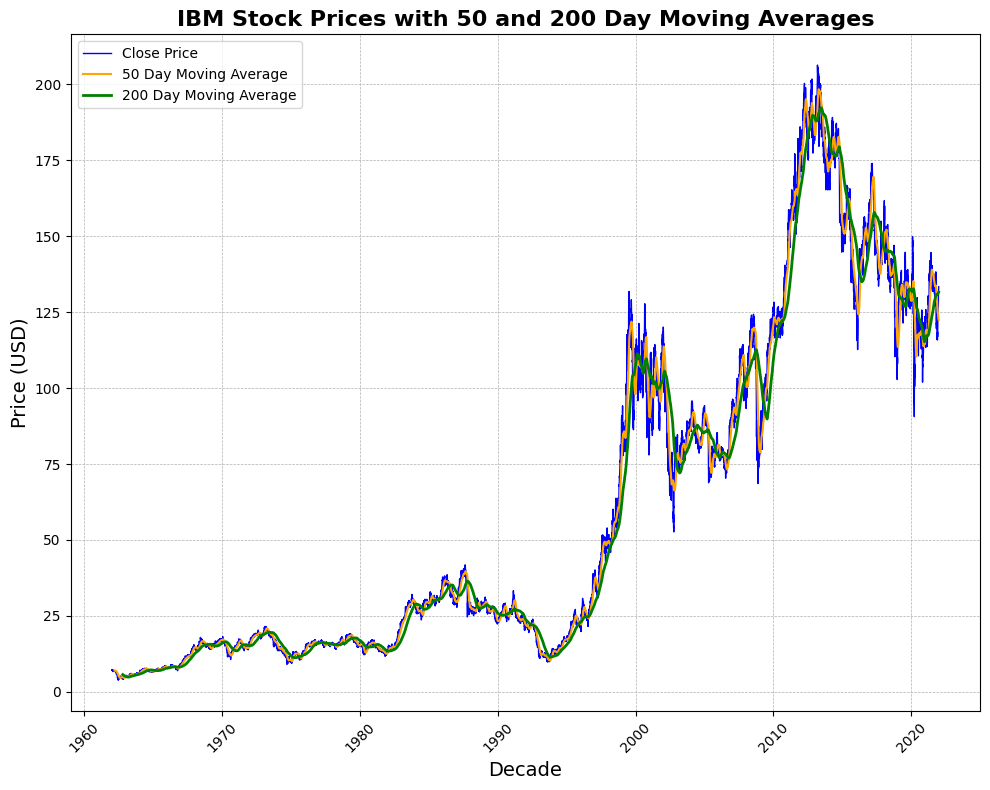

In [15]:
strategy2 = ibm.copy()

strategy2["Close"] = pd.to_numeric(strategy2["Close"], errors = "coerce")

strategy2["50 Day Moving Average"] = strategy2["Close"].rolling(50).mean()
strategy2["200 Day Moving Average"] = strategy2["Close"].rolling(200).mean()

plt.figure(figsize = (10, 8))
plt.plot(strategy2.index, strategy2["Close"], label = "Close Price", color = "blue", linewidth = 1)

plt.plot(strategy2.index, strategy2["50 Day Moving Average"], label = "50 Day Moving Average", color = "orange", linewidth = 1.5)
plt.plot(strategy2.index, strategy2["200 Day Moving Average"], label = "200 Day Moving Average", color = "green", linewidth = 2)

plt.title("IBM Stock Prices with 50 and 200 Day Moving Averages", fontsize = 16, fontweight = "bold")
plt.xlabel("Decade", fontsize = 14)
plt.ylabel("Price (USD)", fontsize = 14)

plt.grid(True, which = "both", linestyle = "--", linewidth = 0.5)
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

In [16]:
strategy2["50 Day Moving Average"] = strategy2["Close"].rolling(50).mean()
strategy2["200 Day Moving Average"] = strategy2["Close"].rolling(200).mean()

strategy2.dropna().head(3)

,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day,50 Day Moving Average,200 Day Moving Average
Date,,,,,,,,,
1962-10-15,4.550669,4.678139,4.550669,4.678139,0.979933,972780,0.954566,4.821351,5.702366
1962-10-16,4.678139,4.697259,4.557043,4.557043,0.954566,1317960,0.965248,4.815615,5.688695
1962-10-17,4.557043,4.652645,4.531549,4.608031,0.965248,1443480,0.948225,4.812620,5.674960


In [17]:
strategy2["Y2"] = np.where(strategy2["50 Day Moving Average"] > strategy2["200 Day Moving Average"], 1, -1)

**Define feature variable "X" & label / target variable "y".**

In [18]:
strategy1.isnull().any()

Open                  False
High                  False
Low                   False
Close                 False
Adj Close             False
Volume                False
Adj Close Next Day    False
Y1                    False
dtype: bool

In [19]:
strategy2.isnull().any()

Open                      False
High                      False
Low                       False
Close                     False
Adj Close                 False
Volume                    False
Adj Close Next Day        False
50 Day Moving Average      True
200 Day Moving Average     True
Y2                        False
dtype: bool

In [20]:
mask = False

for col in strategy2.columns:
    mask = mask | strategy2[col].isnull()

strategy2Nulls = strategy2[mask]

In [21]:
strategy2 = strategy2[208:]

In [22]:
strategy2.isnull().any()

Open                      False
High                      False
Low                       False
Close                     False
Adj Close                 False
Volume                    False
Adj Close Next Day        False
50 Day Moving Average     False
200 Day Moving Average    False
Y2                        False
dtype: bool

In [23]:
strategy2.head(3)

,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day,50 Day Moving Average,200 Day Moving Average,Y2
Date,,,,,,,,,,
1962-10-26,4.295730,4.295730,4.196941,4.225621,0.885143,1623915,0.919855,4.739898,5.577159,-1
1962-10-29,4.308477,4.394519,4.308477,4.391332,0.919855,3687150,0.939214,4.728426,5.563010,-1
1962-10-30,4.391332,4.486934,4.348311,4.483748,0.939214,2769285,0.923860,4.717718,5.549705,-1


**Split data into training & test sets, using an 80 / 20 percent ratio.**

Pre-processing & training the test split.

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

In [25]:
X1 = strategy1.iloc[:, : -1].values
y1 = strategy1.iloc[:, -1].values

X2 = strategy2.iloc[:, : -1].values
y2 = strategy2.iloc[:, -1].values

In [26]:
def splitAndScale(X, y, test_size = 0.20):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = test_size)
    scaler = StandardScaler()
    XTrain = scaler.fit_transform(XTrain)
    XTest = scaler.transform(XTest)
    return XTrain, XTest, yTrain, yTest

X1Train, X1Test, y1Train, y1Test = splitAndScale(X1, y1)
X2Train, X2Test, y2Train, y2Test = splitAndScale(X2, y2)


**Training and predicting classifiers, taking default parameters.**

In [27]:
strategy1["Y1"].value_counts()

Y1
0    7703
1    7400
Name: count, dtype: int64

In [28]:
strategy2["Y2"].value_counts()

Y2
 1    8900
-1    5995
Name: count, dtype: int64

**Model Implementation**

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report

from xgboost import XGBClassifier
from sklearn.svm import SVC

In [30]:
modelsStrategy1 = [KNeighborsClassifier(), SVC(), RandomForestClassifier(), GradientBoostingClassifier()]
fittedModelsStrategy1 = {}

for i, model  in enumerate(modelsStrategy1):
    model.fit(X1Train, y1Train)
    fittedModelsStrategy1[f"Strategy1_{model.__class__.__name__}"] = model

y1TrainMapped = np.where(y1Train == -1, 0, y1Train)
XGB1 = XGBClassifier().fit(X1Train, y1TrainMapped)
fittedModelsStrategy1["Strategy1_XGBClassifier"] = XGB1

modelsStrategy2 = [KNeighborsClassifier(), SVC(), RandomForestClassifier(), GradientBoostingClassifier()]
fittedModelsStrategy2 = {}

for i, model  in enumerate(modelsStrategy2):
    model.fit(X2Train, y2Train)
    fittedModelsStrategy2[f"Strategy2_{model.__class__.__name__}"] = model

y2TrainMapped = np.where(y2Train == -1, 0, y2Train)
XGB2 = XGBClassifier().fit(X2Train, y2TrainMapped)
fittedModelsStrategy2["Strategy2_XGBClassifier"] = XGB2

In [31]:
fittedModelsStrategy1["KNN1"] = fittedModelsStrategy1["Strategy1_KNeighborsClassifier"]
del fittedModelsStrategy1["Strategy1_KNeighborsClassifier"]

fittedModelsStrategy2["KNN2"] = fittedModelsStrategy2["Strategy2_KNeighborsClassifier"]
del fittedModelsStrategy2["Strategy2_KNeighborsClassifier"]

fittedModelsStrategy1["SVM1"] = fittedModelsStrategy1["Strategy1_SVC"]
del fittedModelsStrategy1["Strategy1_SVC"]

fittedModelsStrategy2["SVM2"] = fittedModelsStrategy2["Strategy2_SVC"]
del fittedModelsStrategy2["Strategy2_SVC"]

fittedModelsStrategy1["RF1"] = fittedModelsStrategy1["Strategy1_RandomForestClassifier"]
del fittedModelsStrategy1["Strategy1_RandomForestClassifier"]

fittedModelsStrategy2["RF2"] = fittedModelsStrategy2["Strategy2_RandomForestClassifier"]
del fittedModelsStrategy2["Strategy2_RandomForestClassifier"]

fittedModelsStrategy1["GB1"] = fittedModelsStrategy1["Strategy1_GradientBoostingClassifier"]
del fittedModelsStrategy1["Strategy1_GradientBoostingClassifier"]

fittedModelsStrategy2["GB2"] = fittedModelsStrategy2["Strategy2_GradientBoostingClassifier"]
del fittedModelsStrategy2["Strategy2_GradientBoostingClassifier"]

fittedModelsStrategy1["XGB1"] = fittedModelsStrategy1["Strategy1_XGBClassifier"]
del fittedModelsStrategy1["Strategy1_XGBClassifier"] 

fittedModelsStrategy2["XGB2"] = fittedModelsStrategy2["Strategy2_XGBClassifier"]
del fittedModelsStrategy2["Strategy2_XGBClassifier"]

In [32]:
def generateReportTable(fittedModelsStrategy, XTrain, yTrain, XTest, yTest):
    reportTable = []

    for key, model in fittedModelsStrategy.items(): 
        if isinstance(model, XGBClassifier):
            yTrainMapped = np.where(yTrain == -1, 0, yTrain)
            yTrainPred = model.predict(XTrain)
            yTestPred = model.predict(XTest)           
            trainReport = classification_report(yTrainMapped, yTrainPred, output_dict = True)
            testReport = classification_report(yTest, yTestPred, output_dict = True)
            rocAucTrain = roc_auc_score(yTrain, yTrainPred)
            rocAucTest = roc_auc_score(yTest, yTestPred)
            
        else:
            yTrainPred = model.predict(XTrain)
            yTestPred = model.predict(XTest)
            trainReport = classification_report(yTrain, yTrainPred, output_dict = True)
            testReport = classification_report(yTest, yTestPred, output_dict = True)            
            rocAucTrain = roc_auc_score(yTrain, yTrainPred)
            rocAucTest = roc_auc_score(yTest, yTestPred)

        newRow = {
            "Model": key, "Train Accuracy": trainReport["accuracy"],
            "Test Accuracy": testReport["accuracy"],
            "Train Precision": trainReport["macro avg"]["precision"],
            "Test Precision": testReport["macro avg"]["precision"],
            "Train Recall": trainReport["macro avg"]["recall"],
            "Test Recall": testReport["macro avg"]["recall"],
            "Train F1": trainReport["macro avg"]["f1-score"],
            "Test F1": testReport["macro avg"]["f1-score"],
            "Train ROC-AUC": rocAucTrain, "Test ROC-AUC": rocAucTest}
        
        reportTable.append(newRow)
    
    reportTable = pd.DataFrame(reportTable)
    return reportTable

In [33]:
reportTableStrategy1 = generateReportTable(fittedModelsStrategy1, X1Train, y1Train, X1Test, y1Test)
reportTableStrategy1

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC-AUC,Test ROC-AUC
0,KNN1,0.717762,0.531281,0.717732,0.530953,0.717402,0.530909,0.717468,0.530855,0.717402,0.530909
1,SVM1,0.568035,0.556107,0.580336,0.565167,0.563337,0.552036,0.541530,0.530464,0.563337,0.552036
2,RF1,1.000000,0.778219,1.000000,0.778829,1.000000,0.777712,1.000000,0.777826,1.000000,0.777712
3,GB1,0.698974,0.657398,0.700494,0.658776,0.697863,0.656302,0.697557,0.655605,0.697863,0.656302
4,XGB1,0.874938,0.779874,0.874880,0.779804,0.874897,0.779783,0.874888,0.779793,0.874897,0.779783


In [34]:
reportTableStrategy2 = generateReportTable(fittedModelsStrategy2, X2Train, y2Train, X2Test, y2Test)
reportTableStrategy2

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1,Train ROC-AUC,Test ROC-AUC
0,KNN2,0.944612,0.912387,0.943425,0.910808,0.941005,0.907690,0.942172,0.909153,0.941005,0.907690
1,SVM2,0.850285,0.858342,0.878082,0.884822,0.819860,0.832934,0.833672,0.845233,0.819860,0.832934
2,RF2,1.000000,0.984894,1.000000,0.984337,1.000000,0.984457,1.000000,0.984397,1.000000,0.984457
3,GB2,0.963494,0.955018,0.966063,0.957543,0.958074,0.949684,0.961674,0.953149,0.958074,0.949684
4,XGB2,0.996979,0.582410,0.996958,0.328412,0.996750,0.329347,0.996854,0.328879,0.996750,0.983391


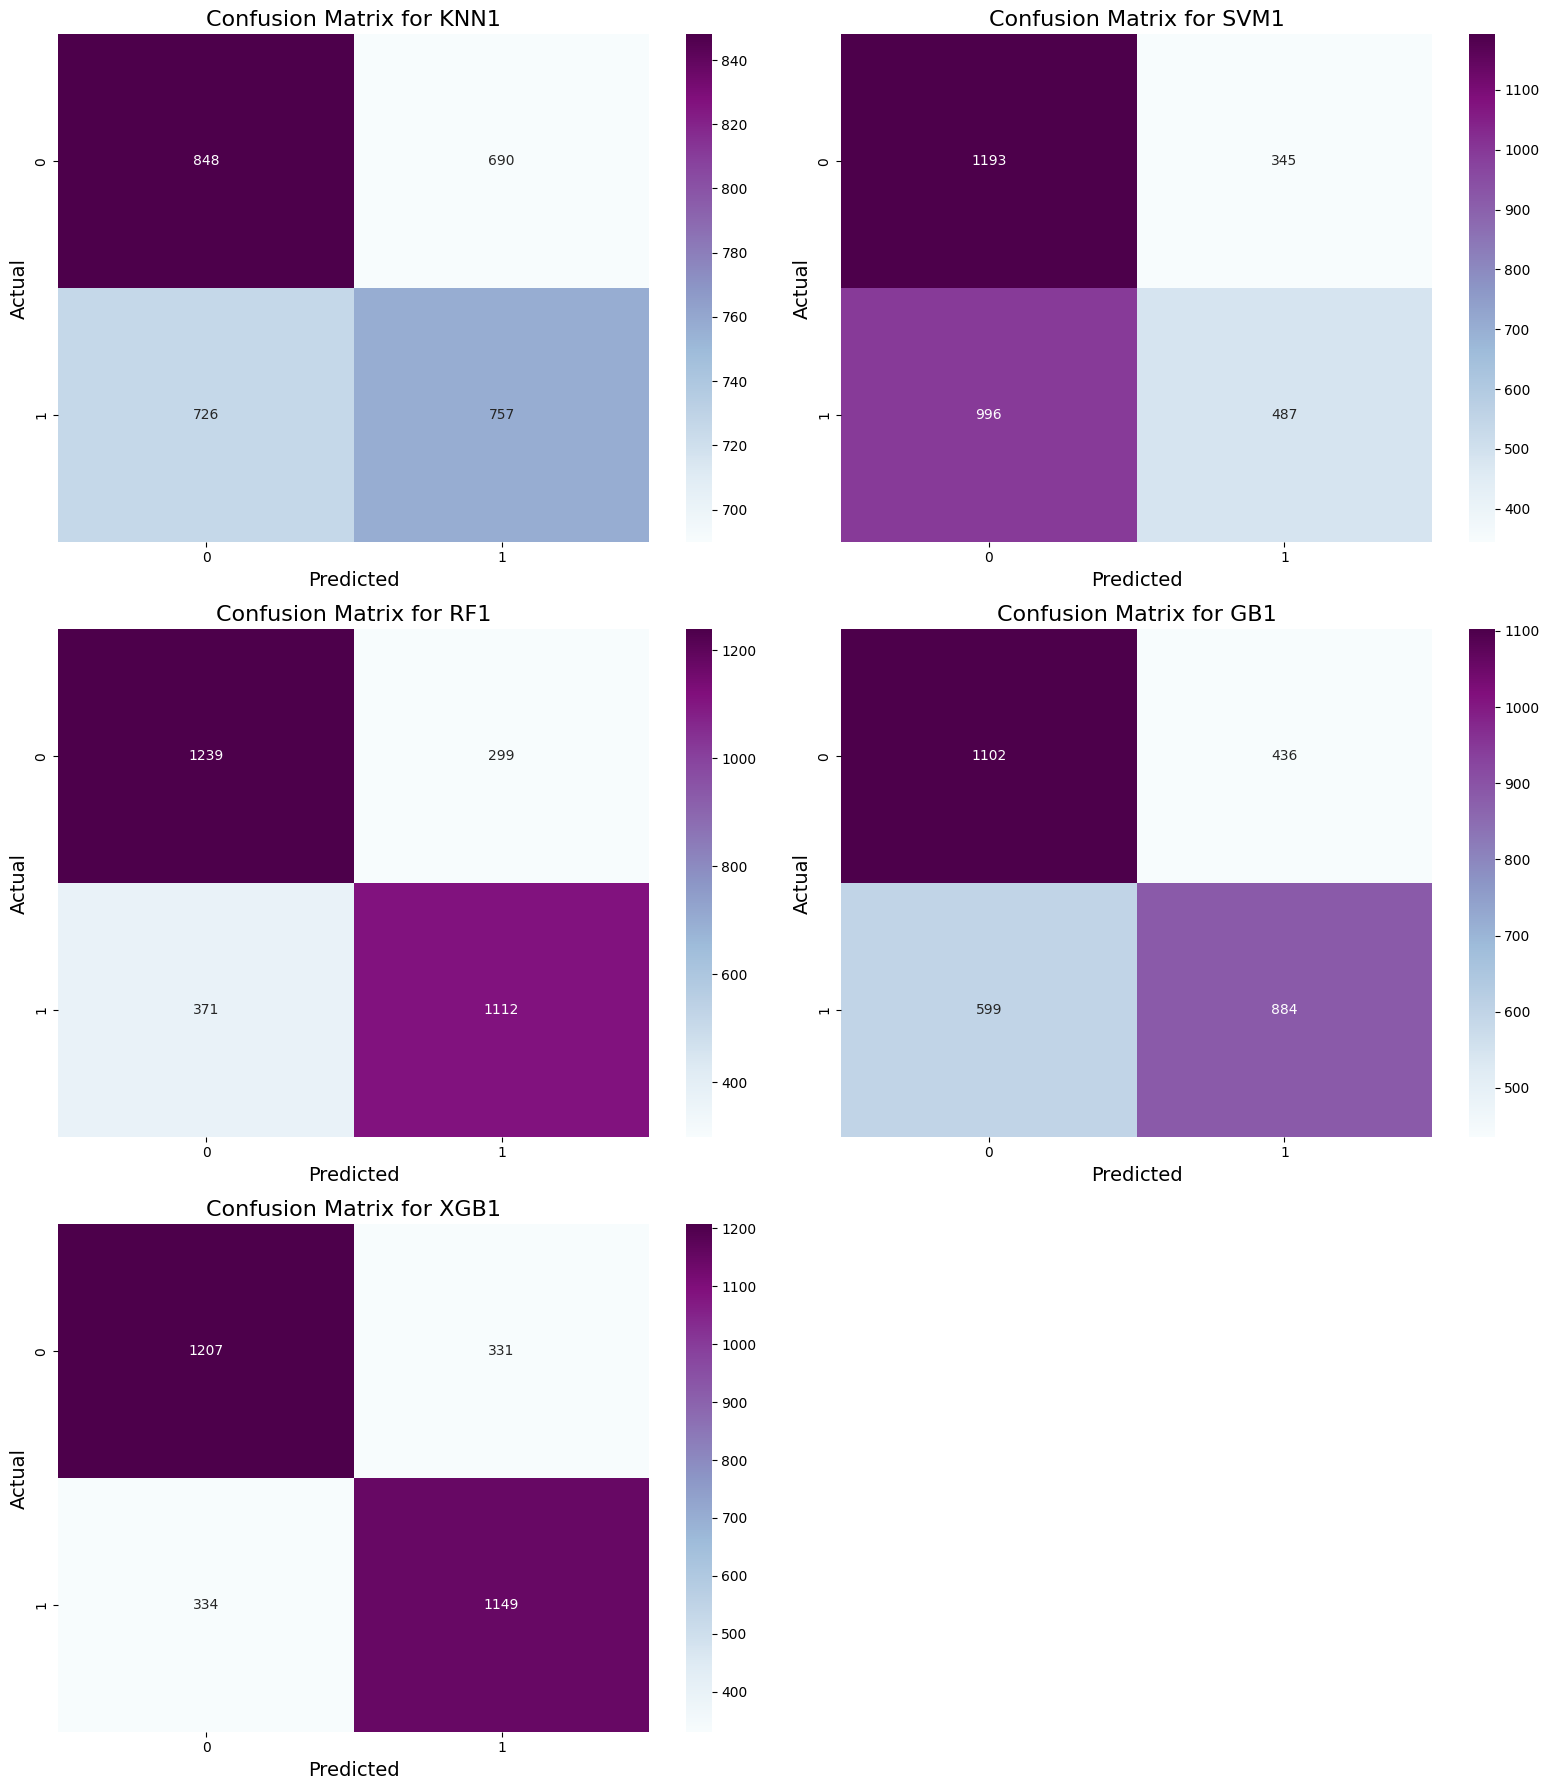

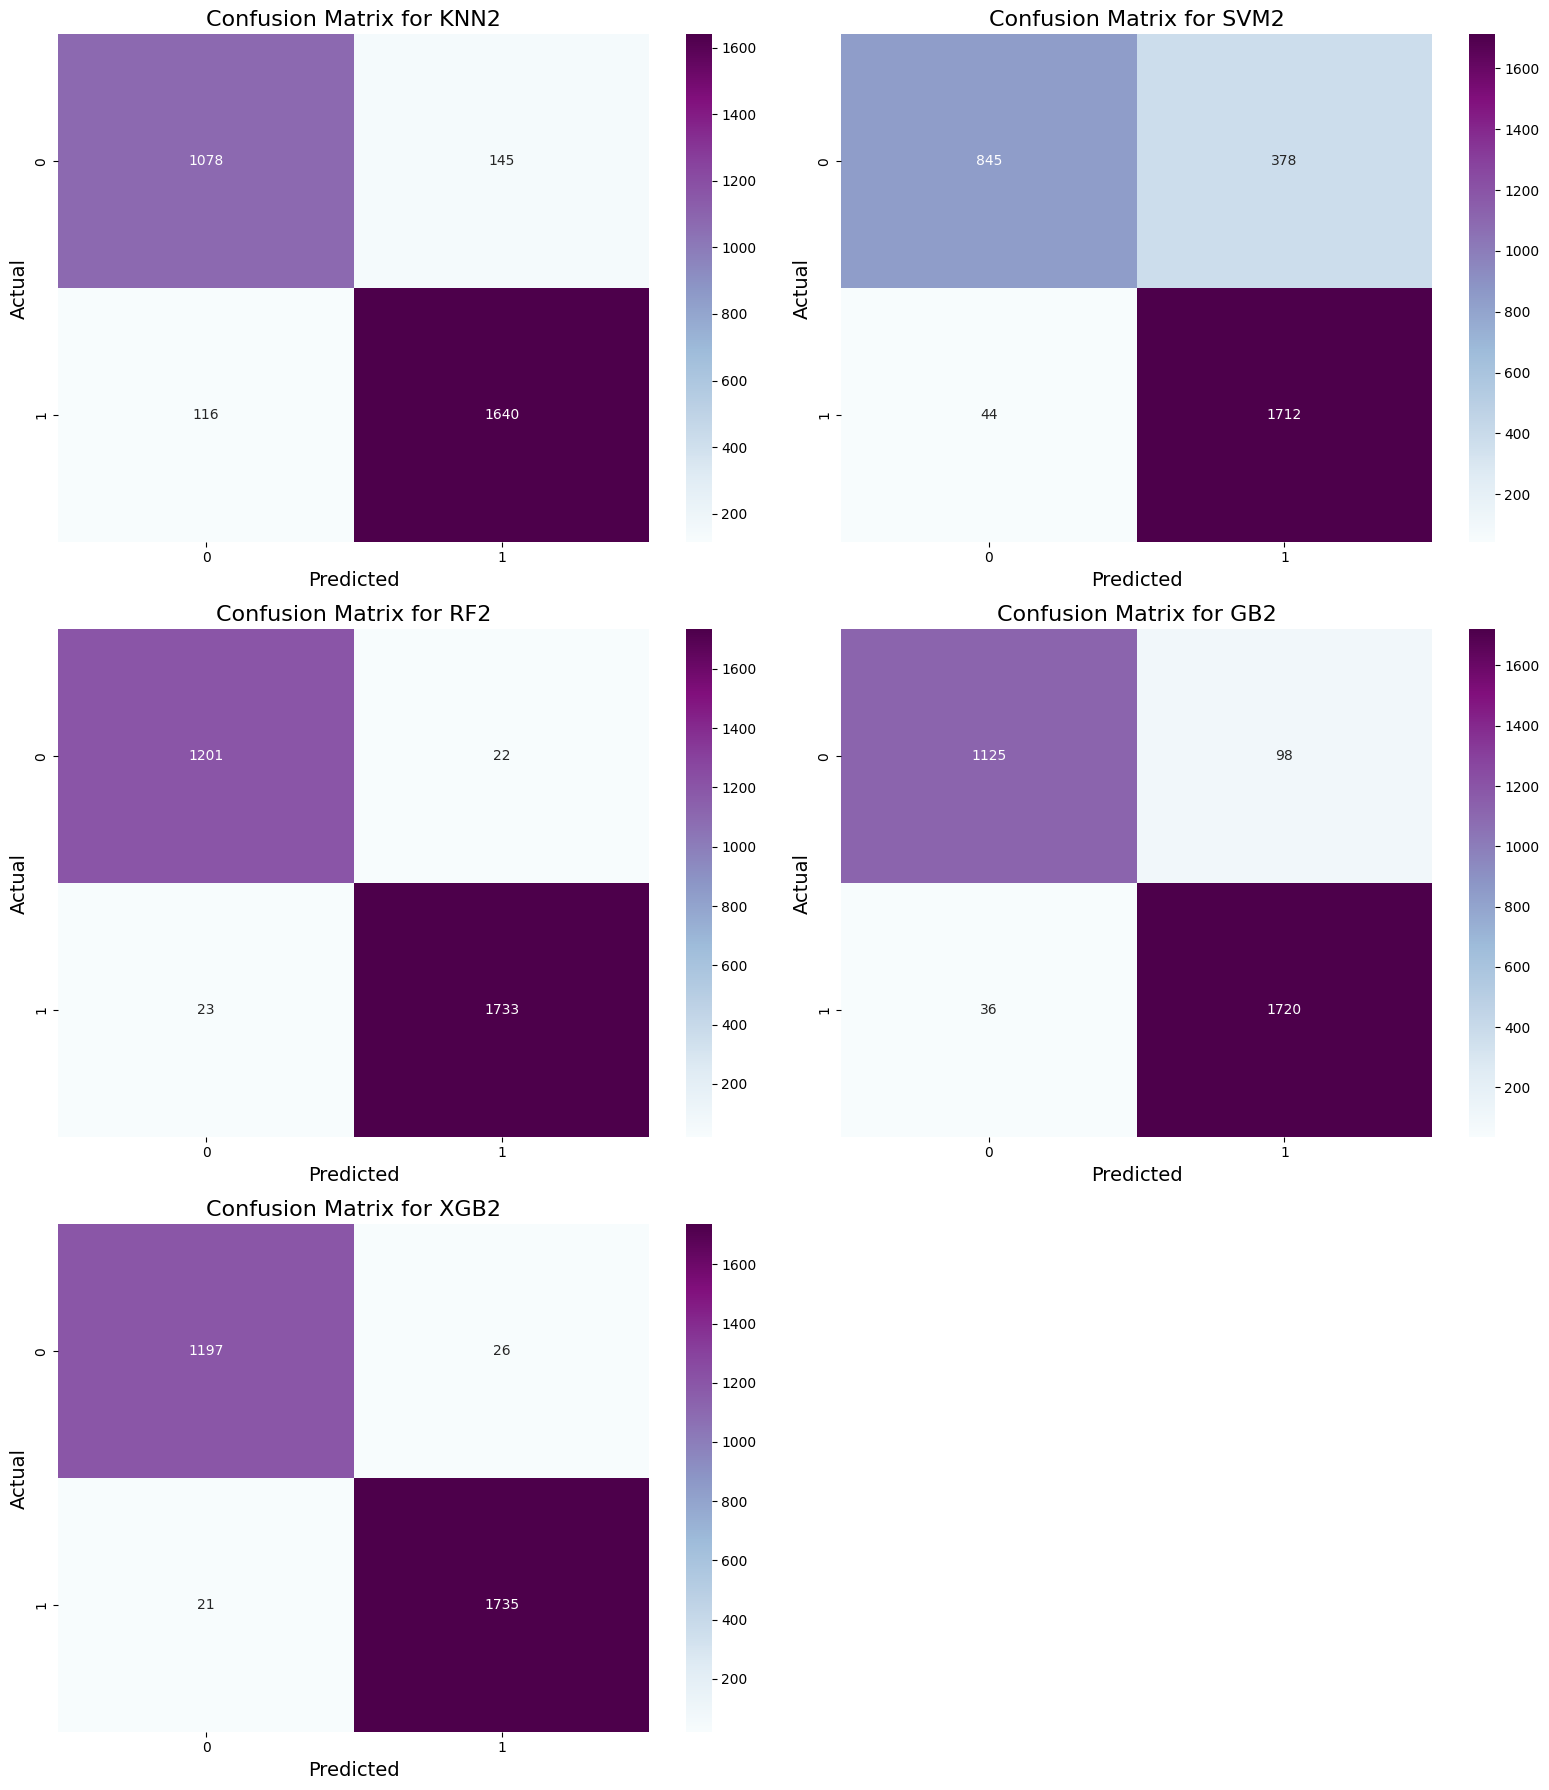

In [35]:
def plotConfusionMatrices(fittedModelsStrategy, X1Test, y1Test, X2Test, y2Test):
    numModels = len(fittedModelsStrategy)
    numRows = (numModels + 1) // 2

    fig, axes = plt.subplots(numRows, 2, figsize = (16, numRows * 6))
    axes = axes.flatten()

    for idx, (key, model) in enumerate(fittedModelsStrategy.items()):
        XTest = X1Test if key.endswith("1") else X2Test
        yTest = y1Test if key.endswith("1") else y2Test
        yPred = model.predict(XTest)
        
        if key.startswith("XGB"):
            yTest = np.where(yTest == -1, 0, yTest)
        
        cm = confusion_matrix(yTest, yPred)

        sns.heatmap(cm, annot = True, fmt = "d", cmap = "BuPu", ax = axes[idx])
        axes[idx].set_title(f"Confusion Matrix for {key}", fontsize = 16)
        axes[idx].set_xlabel("Predicted", fontsize = 14)
        axes[idx].set_ylabel("Actual", fontsize = 14)
        axes[idx].tick_params(axis = "both", which = "major", labelsize = 10)

    for idx in range(len(fittedModelsStrategy), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

confusionMatrices1 = plotConfusionMatrices(fittedModelsStrategy1, X1Test, y1Test, X2Test, y2Test)
confusionMatrices2 = plotConfusionMatrices(fittedModelsStrategy2, X1Test, y1Test, X2Test, y2Test)

Strategies 1 & 2
GB1 0.6421941328340882
GB2 0.9449479691171535
KNN1 0.5288035074731823
KNN2 0.8947633434038268
RF1 0.7185895445728093
RF2 0.9812017455521987
SVM1 0.5343489333460578
SVM2 0.8193185632762671
XGB1 0.7628705879471133
XGB2 0.9841389728096677
[array([0.65268123, 0.64613856, 0.6277626 ]), array([0.93429003, 0.9498993 , 0.95065458]), array([0.52482622, 0.53563447, 0.52594984]), array([0.88796576, 0.89728097, 0.8990433 ]), array([0.71971202, 0.72063571, 0.71542091]), array([0.9806143 , 0.98036254, 0.9826284 ]), array([0.53053625, 0.53538614, 0.53712441]), array([0.81596173, 0.82049345, 0.8215005 ]), array([0.76042701, 0.76111249, 0.76707226]), array([0.98237664, 0.98690836, 0.98313192])]


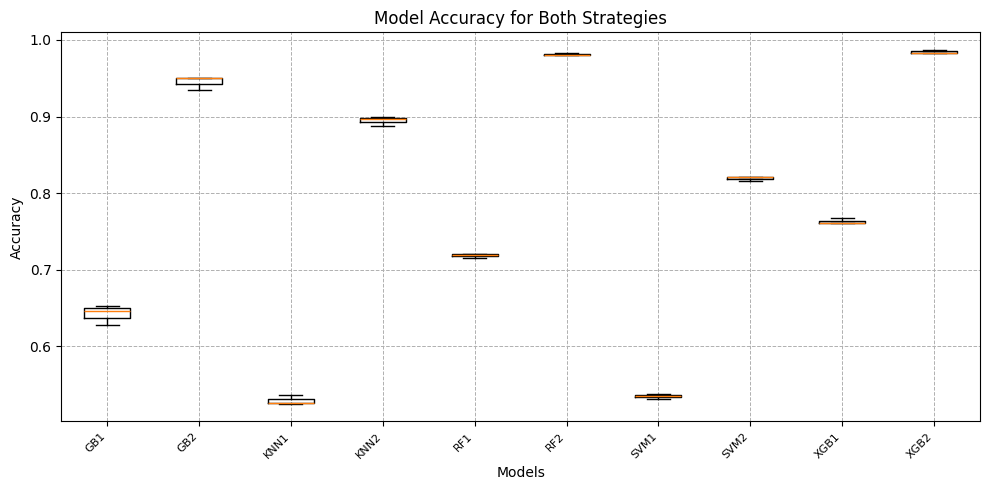

In [36]:
fittedModelsStrategies = {**fittedModelsStrategy1, **fittedModelsStrategy2}
fittedModelsStrategies = dict(sorted(fittedModelsStrategies.items()))

def classificationModels(fittedModelsStrategy, X1Train, X2Train, y1Train, y2Train):
    modelOutcomes = []
    modelNames = []

    for key, model in fittedModelsStrategies.items():
        if isinstance(model, XGBClassifier):
            if key.endswith("1"):
                yTrainMapped = np.where(y1Train == -1, 0, y1Train)
                results = cross_val_score(model, X1Train, yTrainMapped, cv = 3, scoring = "accuracy", n_jobs = -1, verbose = 0)
            else:
                yTrainMapped = np.where(y2Train == -1, 0, y2Train)
                results = cross_val_score(model, X2Train, yTrainMapped, cv = 3, scoring = "accuracy", n_jobs = -1, verbose = 0)
        else:
            if key.endswith("1"):
                results = cross_val_score(model, X1Train, y1Train, cv = 3, scoring = "accuracy", n_jobs = -1, verbose = 0)
            else:
                results = cross_val_score(model, X2Train, y2Train, cv = 3, scoring = "accuracy", n_jobs = -1, verbose = 0)

        print(key, results.mean())
        modelOutcomes.append(results)
        modelNames.append(key)

    print(modelOutcomes)

    fig, ax = plt.subplots(figsize = (10, 5))
    ax.boxplot(modelOutcomes)

    ax.set_xticklabels(modelNames, rotation = 45, ha = "right", fontsize = 8)
    ax.set_xlabel("Models", fontsize = 10)
    ax.set_ylabel("Accuracy", fontsize = 10)
    ax.set_title("Model Accuracy for Both Strategies", fontsize = 12)
    ax.grid(True, linestyle = "--", linewidth = 0.7)
    
    plt.tight_layout()
    plt.show()

print("Strategies 1 & 2")
bothStrategies = classificationModels(fittedModelsStrategies, X1Train, X2Train, y1Train, y2Train)

**Tuning classifiers**

In [37]:
gb1 = GradientBoostingClassifier(n_estimators = 300, max_leaf_nodes = 10)
gb1.fit(X1Train, y1Train)
gb1YPred = gb1.predict(X1Test)

gb2 = GradientBoostingClassifier(n_estimators = 300, max_leaf_nodes = 10)
gb2.fit(X2Train, y2Train)
gb2YPred = gb2.predict(X2Test)

In [38]:
print("Feature Importance of Gradient Boosting Classifier with Parameters, Strategy 1:")
for name, score in zip(strategy1, gb1.feature_importances_):
    print(name, score)

Feature Importance of Gradient Boosting Classifier with Parameters, Strategy 1:
Open 0.0035908557928690833
High 0.005796073979282113
Low 0.007822086198666402
Close 0.016021900465171875
Adj Close 0.4727032818066991
Volume 0.023512914400138845
Adj Close Next Day 0.47055288735717254


In [39]:
print("Feature Importance of Gradient Boosting Classifier with Parameters, Strategy 2:")
for name, score in zip(strategy2, gb2.feature_importances_):
    print(name, score)

Feature Importance of Gradient Boosting Classifier with Parameters, Strategy 2:
Open 0.0341572544634136
High 0.047625258661692836
Low 0.045887841320855785
Close 0.011549254860599637
Adj Close 0.038392673139228964
Volume 0.0011318830760170748
Adj Close Next Day 0.008752751695130555
50 Day Moving Average 0.3770628936187276
200 Day Moving Average 0.43544018916433397


In [40]:
GB1 = fittedModelsStrategy1["GB1"]
GB2 = fittedModelsStrategy2["GB2"]

gb = {GB1, GB2}

y1Pred = GB1.predict(X1Test)
y2Pred = GB2.predict(X2Test)

In [41]:
gb1 = GradientBoostingClassifier(n_estimators = 20, learning_rate = 0.5, max_features = 2, max_depth = 2, random_state = 0)
gb1.fit(X1Train, y1Train)
gb1YPred = gb1.predict(X1Test)
print("GB1 Accuracy Score (Training): {0:.6f}".format(gb1.score(X1Train, y1Train)))
print("GB1 Accuracy Score (Testing): {0:.6f}".format(gb1.score(X1Test, y1Test)))
print("GB1 F1-Score (Testing): ", f1_score(y1Test, gb1YPred))

print("\n")

gb2 = GradientBoostingClassifier(n_estimators = 20, learning_rate = 0.5, max_features = 2, max_depth = 2, random_state = 0)
gb2.fit(X2Train, y2Train)
gb2YPred = gb2.predict(X2Test)
print("GB2 Accuracy Score (Training): {0:.6f}".format(gb2.score(X2Train, y2Train)))
print("GB2 Accuracy Score (Testing): {0:.6f}".format(gb2.score(X2Test, y2Test)))
print("GB2 F1-Score (Testing): ", f1_score(y2Test, gb2YPred))

GB1 Accuracy Score (Training): 0.557524
GB1 Accuracy Score (Testing): 0.521020
GB1 F1-Score (Testing):  0.5210195299569679


GB2 Accuracy Score (Training): 0.787764
GB2 Accuracy Score (Testing): 0.773414
GB2 F1-Score (Testing):  0.8228811335607452


In [42]:
def generateGbReport(gb, XTrain, yTrain, XTest, yTest):
    reportTable = []

    for key, model in gb.items(): 
            yTrainPred = model.predict(XTrain)
            yTestPred = model.predict(XTest)
            trainReport = classification_report(yTrain, yTrainPred, output_dict = True)
            testReport = classification_report(yTest, yTestPred, output_dict = True)            
            rocAucTrain = roc_auc_score(yTrain, yTrainPred)
            rocAucTest = roc_auc_score(yTest, yTestPred)

    reportTable.append({"Model": key, "Train Accuracy": trainReport["accuracy"], "Test Accuracy": testReport["accuracy"],
                        "Train Precision": trainReport["macro avg"]["precision"], "Test Precision": testReport["macro avg"]["precision"],
                        "Train Recall": trainReport["macro avg"]["recall"], "Test Recall": testReport["macro avg"]["recall"],
                        "Train F1": trainReport["macro avg"]["f1-score"], "Test F1": testReport["macro avg"]["f1-score"],
                        "Train ROC-AUC": rocAucTrain, "Test ROC-AUC": rocAucTest})
            
    return reportTable

gbStrategy1 = generateGbReport(fittedModelsStrategy1, X1Train, y1Train, X1Test, y1Test)
gbStrategy2 = generateGbReport(fittedModelsStrategy2, X2Train, y2Train, X2Test, y2Test)

print("Report for Strategies 1 & 2:")
print("{:<25} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
    "Model", "Train Accuracy", "Test Accuracy", "Train Precision", "Test Precision", "Train Recall", "Test Recall",
    "Train F1", "Test F1", "Train ROC-AUC", "Test ROC-AUC"))

for row in gbStrategy1:
    print("{:<25} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f}".
          format(row["Model"], row["Train Accuracy"], row["Test Accuracy"], row["Train Precision"], row["Test Precision"],
                 row["Train Recall"], row["Test Recall"], row["Train F1"], row["Test F1"], row["Train ROC-AUC"], row["Test ROC-AUC"]))

for row in gbStrategy2:
    print("{:<25} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f}".
          format(row["Model"], row["Train Accuracy"], row["Test Accuracy"], row["Train Precision"], row["Test Precision"],
                 row["Train Recall"], row["Test Recall"], row["Train F1"], row["Test F1"], row["Train ROC-AUC"], row["Test ROC-AUC"]))

Report for Strategies 1 & 2:
Model                     Train Accuracy  Test Accuracy   Train Precision Test Precision  Train Recall    Test Recall     Train F1        Test F1         Train ROC-AUC   Test ROC-AUC   
XGB1                      0.8749          0.7799          0.8749          0.7798          0.8749          0.7798          0.8749          0.7798          0.8749          0.7798         
XGB2                      0.5983          0.5824          0.3324          0.3284          0.3326          0.3293          0.3325          0.3289          0.9967          0.9834         


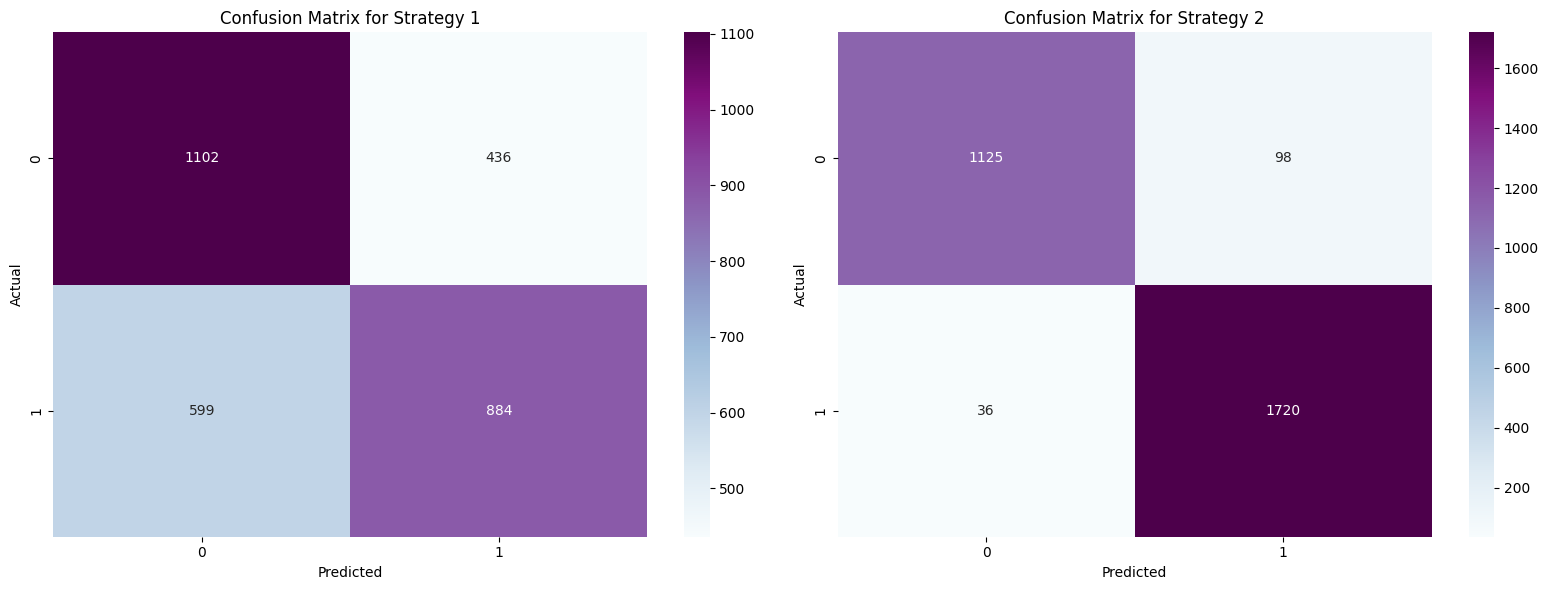

In [43]:
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

cm1 = confusion_matrix(y1Test, y1Pred)
sns.heatmap(cm1, annot = True, fmt = "d", cmap = "BuPu", ax = axes[0])
axes[0].set_title("Confusion Matrix for Strategy 1")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

cm2 = confusion_matrix(y2Test, y2Pred)
sns.heatmap(cm2, annot = True, fmt = "d", cmap = "BuPu", ax = axes[1])
axes[1].set_title("Confusion Matrix for Strategy 2")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [44]:
print("Strategy 1 Gradient Boosting")
print(classification_report(y1Test, y1Pred))

print("\n Strategy 2 Gradient Boosting")
print(classification_report(y2Test, y2Pred))

Strategy 1 Gradient Boosting
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1538
           1       0.67      0.60      0.63      1483

    accuracy                           0.66      3021
   macro avg       0.66      0.66      0.66      3021
weighted avg       0.66      0.66      0.66      3021


 Strategy 2 Gradient Boosting
              precision    recall  f1-score   support

          -1       0.97      0.92      0.94      1223
           1       0.95      0.98      0.96      1756

    accuracy                           0.96      2979
   macro avg       0.96      0.95      0.95      2979
weighted avg       0.96      0.96      0.95      2979

